In [11]:
import sys
sys.path.append('../')
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from smodels.theory.element import Element
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.graphTools import treeToBrackets, ParticleNode, drawTree, getTreeRoot
from smodels.tools.physicsUnits import fb

### Load model

In [2]:
slhafile = '../inputFiles/slha/lightEWinos.slha'
model = Model(BSMparticles=BSMList, SMparticles=SMList)
model.updateParticles(inputFile=slhafile)


### Create node with primary particle

In [3]:
c2 = model.getParticlesWith(pdg=1000037)[0]
mom = ParticleNode(particle=c2,nodeNumber=1)

### Create Tree with primary particle

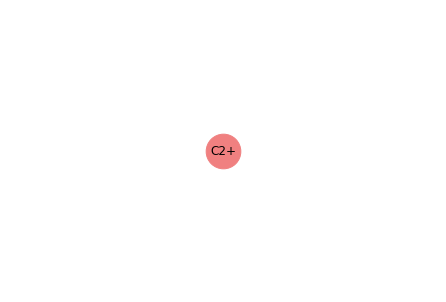

In [4]:
tree = nx.DiGraph()
tree.add_node(mom)
drawTree(tree)

### Add decay to tree

In [5]:
def addDecay(tree,mom,decay):
    # Create new tree with decay:
    inode = mom.node
    for pdg in decay.ids:
        inode += 1
        ptc = model.getParticlesWith(pdg=pdg)[0]
        node = ParticleNode(particle=ptc,nodeNumber=inode)
        tree.add_node(node)
        tree.add_edge(mom,node)
        tree.graph['weight'] *= decay.br 
        
def decayDaughter(tree,daughter):
    
    newTreeList = []
    
    if daughter.particle.isStable() or not daughter.particle.decays:
        return newTreeList
    
    for decay in daughter.particle.decays:
        if decay is None or not decay.br:
            continue # Skip decays with zero BRs
        newTree = tree.copy()
        addDecay(newTree,daughter,decay)
        newTreeList.append(newTree)
    
    return newTreeList


# treeList = [tree]

# def cascadeDecay(treeList,sigmacut=0.*fb):
    
    
#     newTreeList = []
#     for tree in newTreeList:
#         finalStates = [n for n in tree.nodes() if tree.out_degree(n)==0]
#         newTrees = []
#         # Try to decay all final states
#         for fs in finalStates:
#             newT = decayDaughter(tree,fs) # Try to decay daughter            
#             if not newT:
#                 continue
#             newTrees += newT
        
#         if not newTrees: # Tree is already stable
#             continue
        
#         # Keeep decaying tree:
#         newTrees = cascadeDecay(newTrees,sigmacut=sigmacut)
    
#     if not newTrees:
#         return False
            
    
#     for mom in primaryMothers:
    
#         if br.maxWeight.asNumber(fb) < sigcut.asNumber(fb):
#             continue

#         if br.decayDaughter():
#             unstableBranches.append(br)
#         else:
#             stableBranches.append(br)

#     while unstableBranches:
#         # Store branches after adding one step cascade decay
#         newBranchList = []
#         for inbranch in unstableBranches:
#             if sigcut.asNumber() > 0. and inbranch.maxWeight.asNumber(fb) < sigcut.asNumber(fb):
#                 # Remove the branches above sigcut and with length > topmax
#                 continue

#             #If None appear amongst the decays, add the possibility for the particle not decaying prompt
#             if any(x is None for x in inbranch.oddParticles[-1].decays):
#                 stableBranches.append(inbranch)

#             # Add all possible decays of the R-odd daughter to the original
#             # branch (if any)
#             newBranches = inbranch.decayDaughter()
#             if newBranches:
#                 # New branches were generated, add them for next iteration
#                 newBranchList += [br for br in newBranches
#                                   if br.maxWeight.asNumber(fb) > sigcut.asNumber(fb)]
#             elif inbranch.maxWeight.asNumber(fb) > sigcut.asNumber(fb):
#                 stableBranches.append(inbranch)

#         # Use new unstable branches (if any) for next iteration step
#         unstableBranches = newBranchList        
        
        
        
        
        

# newTrees = addDecayList(tree,mom,c2.decays)

In [ ]:
def cascadeDecay(treeList,sigmacut=0.*fb):
    
    newTrees = []
    for tree in treeList:
        # Check is tree is final:
        unstableFinalStates = []
        for n in tree.nodes():
            if tree.out_degree(n)==0:
                continue
            if n.particle.isStable():
                continue
            if not n.particle.decays:
                continue
            
            unstableFinalStates.append(n)
        
        if not unstableFinalStates:
            continue
        
        for fs in unstableFinalStates:
            newTrees += decayDaughter(tree,fs)
        if not newTrees:
            continue
        newTrees = cascadeDecay(newTrees,sigmacut=sigmacut)
    
    return newTrees
        

In [ ]:
# tree,daughter -> list of trees -> tree -> getDaughter -> tree,daughter ->...